In [1]:
#Pick one school or come up with your own


#schoolname = 'Deer Valley High School'      # in the Deer Valley Unified District
#schoolname = 'Barry Goldwater High School'  # also in the Deer Valley Unified District
schoolname = 'Adobe Mountain School'  # Operated by the Arizona Department of Corrections
#schoolname = 'New River Elementary'      # in the Deer Valley Unified District


In [2]:
import numpy as np
from numpy import random

import matplotlib 
import matplotlib.pyplot as plt

import pandas as pd
from pandas import Series, DataFrame

import sys 

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Enable inline plotting
%matplotlib inline

import re

import itertools

import urllib

In [3]:
print 'Downloading data to file: ed.csv...  File size = 47.1MB   (this normally takes a few minutes)'
print 'Data Info at http://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html'
print 'Data file = http://www2.ed.gov/about/inits/ed/edfacts/data-files/math-achievement-sch-sy2014-15.csv'
urllib.urlretrieve ('http://www2.ed.gov/about/inits/ed/edfacts/data-files/math-achievement-sch-sy2014-15.csv', 'ed.csv')
print 'Download complete!'


Data Info at http://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html
Data file = http://www2.ed.gov/about/inits/ed/edfacts/data-files/math-achievement-sch-sy2014-15.csv
Download complete!


In [4]:
#Importing and cleaning data files
#function used to format data file
def convertpercentprof(percentprof):
    if '-' in percentprof:
        match = re.search(r'(\w+)\-(\w+)', percentprof)
        if match: 
            percentprof = (float(match.group(1))
                           +float(match.group(2)))/2.0
            return percentprof
    if 'GE' in percentprof:
        match = re.search(r'GE(\w+)', percentprof)
        if match:
            percentprof = ((100.0-float(match.group(1)))/2.0)
            return percentprof
    if 'GT' in percentprof:
        match = re.search(r'GT(\w+)', percentprof)
        if match:
            percentprof = ((100.0-float(match.group(1)))/2.0)
            return percentprof
    if 'LE' in percentprof:
        match = re.search(r'LE(\w+)', percentprof)
        if match:
            percentprof = ((float(match.group(1))-0.0)/2.0)
            return percentprof
    if 'LT' in percentprof:
        match = re.search(r'LT(\w+)', percentprof)
        if match:
            percentprof = ((float(match.group(1))-0.0)/2.0)
            return percentprof
    if 'PS' in percentprof:
        percentprof = np.nan
        return percentprof
    if 'n/a' in percentprof:
        percentprof = np.nan
        return percentprof
    if '.' == percentprof:
        percentprof = np.nan
        return percentprof
    return percentprof

In [5]:
#build dictionary that contains columns to be converted, columns 8-232
convertdict = {}
for i in range(8, 232,2):
    convertdict[i]=convertpercentprof
#print convertdict

In [6]:
#reading in data file
print "Reading in data file  (this normally takes a few minutes)"
na_valuesList = ['PS', '.', 'n/a']    
df_math = pd.read_csv('ed.csv', 
                      sep=',', 
                      na_values = na_valuesList, na_filter = True,
                      converters = convertdict,
                      skipinitialspace = True,
                      low_memory=False)


In [7]:
# convert types to numeric
for i in range(8,232,2):
    df_math.ix[:,i] = pd.to_numeric(df_math.ix[:,i], errors='raise')
#df_math.columns
#df_math

In [8]:
#normalize and clean data

df_math_clean = df_math.copy()
del df_math_clean['FIPST']
del df_math_clean['LEAID']
del df_math_clean['NCESSCH']
del df_math_clean['STNAM']
del df_math_clean['LEANM']
del df_math_clean['SCHNAM']
del df_math_clean['DATE_CUR']

df_math_np = df_math_clean.values #returns a numpy array
df_math_np = np.nan_to_num(df_math_np)

min_max_scaler = preprocessing.MinMaxScaler()
df_math_np_scaled = min_max_scaler.fit_transform(df_math_np)
df_math_scaled = pd.DataFrame(df_math_np_scaled)


Building the model...


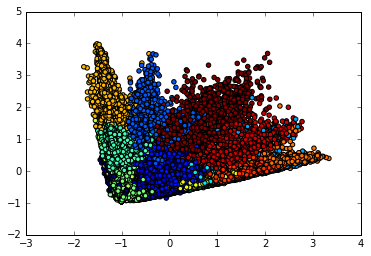

In [9]:
print 'Building the model...  (this normally takes a few minutes)'

kmeans_model = KMeans(n_clusters=15, random_state=1)

# fit the model using the good, scaled columns
kmeans_model.fit(df_math_scaled)
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_
inertia = kmeans_model.inertia_

# create PCA model
pca_2 = PCA(2)
# fit the PCA model on the numeric columns
plot_columns = pca_2.fit_transform(df_math_scaled)
# make a scatter plot of each school, colored according to Class
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
plt.show()


In [10]:
# put cluster class on main df
df_math_withClass = df_math.copy()
df_math_withClass['Class'] = pd.Series(labels,index=df_math_withClass.index)
#df_math_withClass   # uncomment this to view dataframe
# count number of items in each group
#df_math_withClass.groupby('Class').count()
# show stats for group by column
#df_math_withClass.groupby('Class').describe()

In [11]:


newState = 'WASHINGTON'  # needs to be capitalized
x = df_math_withClass.loc[df_math_withClass['SCHNAM']==schoolname]
if len(x)>1:
    print 'More than one', schoolname, 'exists in the U.S.'
    for i in range(len(x)):
        print x.LEANM.values[i]
#print "Using school: ", schoolname,' from: ', x.LEANM.values[0]
y = x.Class.values[0]
print 'The following schools in the state of: ', newState, 'are similar to: ', schoolname, 'in school district:', x.LEANM.values[0]
newSchools = df_math_withClass.loc[df_math_withClass['Class']==y].loc[df_math_withClass['STNAM']==newState]
print newSchools['SCHNAM'].head(50)

The following schools in the state of:  WASHINGTON are similar to:  Deer Valley High School in school district: Deer Valley Unified District
83665               Enumclaw Sr High School
83705                 Anacortes High School
83710                 Arlington High School
83723             Auburn Senior High School
83739          Auburn Riverside High School
83741       Auburn Mountainview High School
83747                Bainbridge High School
83758             Battle Ground High School
83792                 Sammamish Senior High
83806                Bellingham High School
83823                 Squalicum High School
83851           Graham Kapowsin High School
83857      Bickleton Elementary & High Schl
83860                    Blaine High School
83879                Bridgeport High School
83884         Burlington Edison High School
83896                     Camas High School
83906                   Cascade High School
83908                  Cashmere High School
83916            Centra